# importing packages

In [1]:
from bs4 import BeautifulSoup
import requests
import time
import os
import pandas as pd
from urllib.parse import urljoin
from functools import reduce
from collections import defaultdict
from difflib import SequenceMatcher

# modules

# very basic for crawling

In [2]:
def download(url="https://www.google.com/search",params={},retries=3):
    """
    input : url(str), parameter(dict)
    output : resp(object)
    
    using package requests, get object resp given url
    for robustness, if error is server error(500s), retry at most 3 times
    otherwise, print error name, error reason, and header
    """
    resp = None
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36"
    header = {"user-agent":user_agent}
    try:
        resp = requests.get(url,params=params,headers=header)
        resp.raise_for_status() #error/event 발생하면 except로 가게해라 
        resp.encoding = None
    except requests.exceptions.HTTPError as e:
        url = url.replace("http://", "https://")
        if e.response.status_code//100==5 and retries>0:
            print(retries)
            resp = download(url,params,retries-1)
        else: 
            print(e.response.status_code)
            print(e.response.reason)
            print(e.response.headers)
            print(url)
    return resp


## URL EXTRACTOR

In [3]:
def get_main_page(query):
    '''
    input : query(str)
    output : list of tuples(text, href)
    
    search from naver given query
    '''
    url = download("https://search.naver.com/search.naver?", params = {'query':query})
    dom = BeautifulSoup(url.text,"lxml")
    hspt_top = lambda dom : list(zip([_["href"] for _ in dom.select('.nsite.section._nsiteTop dl dt a')],
                                [_.text for _ in dom.select('.nsite.section._nsiteTop dl dt b.hl')]))
    hspt_title_link = [(_["href"], _.text) \
                       for _ in dom.select('.title_link') if not is_portal(_["href"])]
    hspt_title_link += hspt_top(dom)
    return hspt_title_link

In [4]:
def get_main_page_dict(query_list):
    '''
    input : list of query(str)
    output : {query : lis of url given url}(dict)
    
    get dictionary having main page list given query 
    '''
    return {query:get_main_page(query) for query in query_list}

In [5]:
def html_re(url): 
    '''
    input : full url(str)
    output : main url(str)
    
    regularization for finding main page
    '''
    main = "/".join(url.split('/')[:3])
    return main

In [6]:
def is_portal(url):
    '''
    input : url(str)
    output : boolean
    
    see whether url is not offical one but other portal site such as facebook
    '''
    portals = ['facebook', 'naver', 'saramin', 'jobplanet', 'facebook', 
               'coupang', '11st', 'incruit','blog', 'jobkorea', 'tistory', 'hidoc']
    return any(p in url for p in portals)

In [7]:
def similar(a, b):
    '''
    input : a(str), b(str)
    output : the number of string in common(int)
    
    betweetn two string, get the number of string in common
    '''
    return SequenceMatcher(None, a, b).get_matching_blocks()[0]

In [8]:
def get_valid_html(HSPT_URL):
    '''
    input :  list of tuples (text, href)
    output : {text, set of urls} (dict)
    
    get valid urls by using rule module 'similar' and 'is_portal' 
    and make them into dictionary
    '''
    HSPT_URL_VALID = {}
    for hspt, url_list in HSPT_URL.items():
        HSPT_URL_VALID.update({hspt:set(html_re(link) for link, name in url_list 
                                        if similar(name, hspt).size > 2
                                        and not is_portal(link))})
    return HSPT_URL_VALID

## HTML REQUEST

In [9]:
def parsing(url):
    '''
    input : url(str)
    output : dom(object)
    
    get dom given url
    '''
    dom_text = get_html_text(url)
    dom = BeautifulSoup(dom_text, 'lxml')
    return dom

In [10]:
def sub_pages(url):
    '''
    input : url(str)
    output : list of tuples(text, href)
    
    get sub pages given url
    '''
    return [(_.text.strip(), _["href"])
            for _ in parsing(url).select('a') 
            if _.has_attr("href") 
            and _.text.strip()
            and "#" not in _["href"]
            and "javascript" not in _["href"]]

In [11]:
def get_sub_pages(main_pages):
    '''
    input : {hspt, list of url}(dict)
    output : list of tuples (text, lisf of urls)
    
    get sub pages given dictionary
    '''
    main_sub_pages = []
    for hspt, url in main_pages.items():
        for u in url:
            main_sub_pages.append((hspt, sub_pages(u)))
    return main_sub_pages

In [12]:
def get_sub_pages(main_pages):
    '''
    input : {hspt, list of url}(dict)
    output : list of tuples (text, lisf of urls)
    
    get sub pages given dictionary
    '''
    main_sub_pages = []
    for hspt, url in main_pages.items():
        for u in url:
            main_sub_pages.append({hspt: sub_pages(u)})
    return main_sub_pages

In [13]:
def root_path_join(row):
    '''
    input : row from HSPT_CHILDREN_URL(Series)
    output : path(str)
    
    made in order to do 'apply' in axis 1
    if html is made of relative url, make it absolute by joining with root url   
    '''
    html = row["url"]
    hspt = row["hspt"]
    if not html.startswith("http"):
        return urljoin(HSPT_URL[hspt][0][0], html)
    return html

In [14]:
def get_html_table(main_sub_pages):
    '''
    input : list having tuples (text, lisf of urls)
    output :list of DataFrame
    
    get html table having text of url, url, depth, url name(hspt)
    we will list these dataframes into list
    '''
    HSPT_CHILDREN_URL_list = []
    for hspt, contents in main_sub_pages:
        HSPT_CHILDREN_URL = pd.DataFrame({'hspt':[], 'url':[],'depth':[],'text':[]})
        zipped = list(zip(*contents))
        if len(zipped):
            HSPT_CHILDREN_URL["text"] = list(zipped[0])
            HSPT_CHILDREN_URL["url"] = list(zipped[1])
            HSPT_CHILDREN_URL["depth"] = [1 for _ in range(len(contents))]
            HSPT_CHILDREN_URL["hspt"] = [hspt for _ in range(len(contents))]
            HSPT_CHILDREN_URL["full_url"] = HSPT_CHILDREN_URL.apply(lambda row: root_path_join(row), axis=1)
            HSPT_CHILDREN_URL_list.append(HSPT_CHILDREN_URL)
    return HSPT_CHILDREN_URL_list

In [15]:
def concat_from_list(df_list):
    '''
    input : list having dataframes
    output : concatened dataframe
    
    concatenate dataframes from list 
    '''
    return reduce(lambda a, b: pd.concat([a,b], axis=0), df_list)

In [16]:
def drop_duplicate_by_column(df, column):
    '''
    input : dataframe, column(str or list of str)
    output : dataFrame 
    
    drop rows having overlapped item in selected column 
    '''
    df_reduced = df.drop_duplicates(column)
    print('{} ->  {}'.format(df.shape[0], df_reduced.shape[0]))
    return df_reduced

## HTML PARSING 

In [17]:
def get_html_text(url):
    '''
    input : url(str)
    output : html(str)
    
    download url and get html text
    '''
    url = download(url)
    return url.text

In [18]:
def html_parsing(df, query):
    '''
    input : dataframe, query(str)
    output : dataframe
    
    find rows having query from given data frame 
    '''
    df_query = df[df["text"].apply(lambda e: query in e)]
    print('{} have {} page'.format(df_query.shape[0], query))
    return df_query

## TABLE PARSING

In [19]:
def table_parsing(html):
    '''
    input : url(str)
    output : list of table(DataFrame)

    get list of table given url
    '''
    table_df_list = []
    soup = parsing(html)
    tables = soup.find_all('table')
    print('table found in {}'.format(html) 
          if tables else "no table in {}".format(html))
    if tables:
        for table in tables:
            table_df = pd.DataFrame()
            table_head = table.find('thead')
            table_body = table.find('tbody')
            if table_head:
                columns_head = table_head.find_all('th')
                columns_head = [c.text for c in columns_head]
            if table_body:
                columns_body = table_body.find_all('th')
                if not columns_body:
                    columns_body = table_body.find_all('td')
                columns_body = [c.text for c in columns_body]
            if table_body:
                rows = table_body.find_all('tr')
                for row in rows:
                    element = row.find_all('td')
                    element = [e.text.replace('\r', '').strip() for e in element]
                    if len(element) == len(columns_body):
                        columns = columns_body
                    else:
                        try:
                            if len(element) == len(columns_head):
                                columns = columns_head
                            else:
                                columns = [_ for _ in range(len(element))]
                        except:
                            columns = [_ for _ in range(len(element))]
                    if columns and element:
                        cols_dict = {c: e for c, e
                                     in zip(columns, element)}
                        table_df = table_df.append(cols_dict, ignore_index=True)
                table_df_list.append(table_df)
                
    table_df_list = [table for table in table_df_list if any(table)]
    return table_df_list

In [20]:
def get_table_list(df):
    '''
    input : dataframe having full_url
    output : list of tables(dataframe)
    
    using table parser, get list of tables given dataframe with full_url 
    '''
    table_list = []
    for _ in df["full_url"][:]:
        table = table_parsing(_)
        if table:
            table_list += [table]
    return table_list

# MAIN

In [21]:
HSPT_LIST = ["연세사랑병원", "연세건우병원", "목동힘찬병원", "우리들병원", "의)상원의료재단부평힘찬병원", "바른세상병원", "의료법인 인당의료재단 부민병원", "의료법인나누리의료재단나누리병원",
            "제일정형외과병원", "나누리수원병원", "안산21세기병원", "대찬병원", "미래병원", "뿌리병원","연세본사랑병원", "바로병원", "의료법인 상원의료재단 부산힘찬병원", "달려라병원",
            "의료법인 토마스의료재단 윌스기념병원", "에이스병원"] 

In [22]:
print(len(HSPT_LIST))

20


# HSPT_URL
병원명이 쿼리로 주어졌을 때 메인페이지를 찾는 과정

In [23]:
HSPT_URL = get_main_page_dict(HSPT_LIST)

In [24]:
HSPT_URL

{'연세사랑병원': [('http://www.yonserang.com/', '강남 연세사랑병원'),
  ('http://www.ysloves.com/', '강북연세병원')],
 '연세건우병원': [('http://www.healthyfriend.co.kr/', '연세건우병원'),
  ('http://www.healthyfriend.co.kr/introduce/directions', '오시는길 - 연세건우병원')],
 '목동힘찬병원': [('https://himchanhospital.com/index.php', '힘찬병원'),
  ('https://himchanhospital.com/index.php/br/notice/27/br_cd/4', '힘찬병원'),
  ('https://himchanhospital.com/index.php/br/notice/27/br_cd/4', '병원')],
 '우리들병원': [('http://busan.wooridul.co.kr/', '부산 우리들병원'),
  ('http://seoul.wooridul.co.kr/', '김포공항 우리들병원'),
  ('https://www.wooridul.co.kr/', '우리들병원')],
 '의)상원의료재단부평힘찬병원': [('https://himchanhospital.com/index.php', '힘찬병원'),
  ('https://himchanhospital.com/index.php/br/notice/27/br_cd/5',
   '의료법인 상원의료재단 부평힘찬병원')],
 '바른세상병원': [('https://www.barunsesang.co.kr/', '척추 관절 진료 바른세상병원')],
 '의료법인 인당의료재단 부민병원': [('https://www.bumin.co.kr/', '부민병원'),
  ('https://www.bumin.co.kr/gupo/', '구포부민병원')],
 '의료법인나누리의료재단나누리병원': [('http://www.nanoori.co.kr/', '나누리병원'),
  (

In [25]:
HSPT_URL_VALID = get_valid_html(HSPT_URL)

In [26]:
HSPT_URL_VALID

{'연세사랑병원': {'http://www.yonserang.com'},
 '연세건우병원': {'http://www.healthyfriend.co.kr'},
 '목동힘찬병원': {'https://himchanhospital.com'},
 '우리들병원': {'http://busan.wooridul.co.kr',
  'http://seoul.wooridul.co.kr',
  'https://www.wooridul.co.kr'},
 '의)상원의료재단부평힘찬병원': {'https://himchanhospital.com'},
 '바른세상병원': {'https://www.barunsesang.co.kr'},
 '의료법인 인당의료재단 부민병원': {'https://www.bumin.co.kr'},
 '의료법인나누리의료재단나누리병원': {'http://gn.nanoori.co.kr', 'http://www.nanoori.co.kr'},
 '제일정형외과병원': {'http://www.cheilos.com'},
 '나누리수원병원': {'http://sw.nanoori.co.kr', 'http://www.nanoori.co.kr'},
 '안산21세기병원': {'http://www.ansan21.com',
  'http://www.mediup.co.kr',
  'https://pf.kakao.com'},
 '대찬병원': {'https://www.daechanhospital.com'},
 '미래병원': {'http://www.miraehos.co.kr', 'http://www.miraehospital.com'},
 '뿌리병원': {'http://www.ppuricj.co.kr'},
 '연세본사랑병원': {'http://www.bucheon-yonserang.com'},
 '바로병원': {'http://www.baro119.co.kr'},
 '의료법인 상원의료재단 부산힘찬병원': {'https://himchanhospital.com'},
 '달려라병원': {'http://www.hos

In [27]:
main_sub_url = get_sub_pages(HSPT_URL_VALID)

404
Not Found
{'Date': 'Mon, 24 Feb 2020 00:46:05 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip'}
https://pf.kakao.com


In [28]:
main_sub_url[0]

{'연세사랑병원': [('&', '../../template/main/main.php'),
  ('로그인', '../../module/login/login.php?return_url=/template/main/main.php?'),
  ('회원가입', '../../module/member/join.php'),
  ('병원소개', '../../template/info/greeting.php'),
  ('인사말', '../../template/info/greeting.php'),
  ('비전 및 미션', '../../template/info/vision.php'),
  ('연세사랑병원의 발자취', '../../template/info/history.php'),
  ('학술활동', '../../module/board/board.php?bo_id=symposium'),
  ('의료진 소개', '../../template/info/info.php'),
  ('층별안내 및 병원둘러보기', '../../template/info/around.php'),
  ('의료장비 소개', '../../template/info/equipment.php'),
  ('언론속의 연세사랑병원', '../../module/board/board.php?bo_id=press_news'),
  ('신문', '../../module/board/board.php?bo_id=press_news'),
  ('방송', '../../module/board/board.php?bo_id=press_media'),
  ('떴다! 내고향 닥터', '../../module/board/board.php?bo_id=6_mov'),
  ('사회공헌', '../../module/board/board.php?bo_id=contribute'),
  ('활동게시판', '../../module/board/board.php?bo_id=contribute'),
  ('사업설명', '../../template/info/contribute.

In [29]:
HSPT_CHILDREN_URL.head()

NameError: name 'HSPT_CHILDREN_URL' is not defined

## HTML PARSER

In [ ]:
unpaid = html_parsing(HSPT_CHILDREN_URL, '비급여')

In [ ]:
unpaid

In [ ]:
table_list = get_table_list(unpaid)

In [ ]:
[len(table) for table in table_list]

# table parsing 결과

# case 1: 잘 되는 경우  

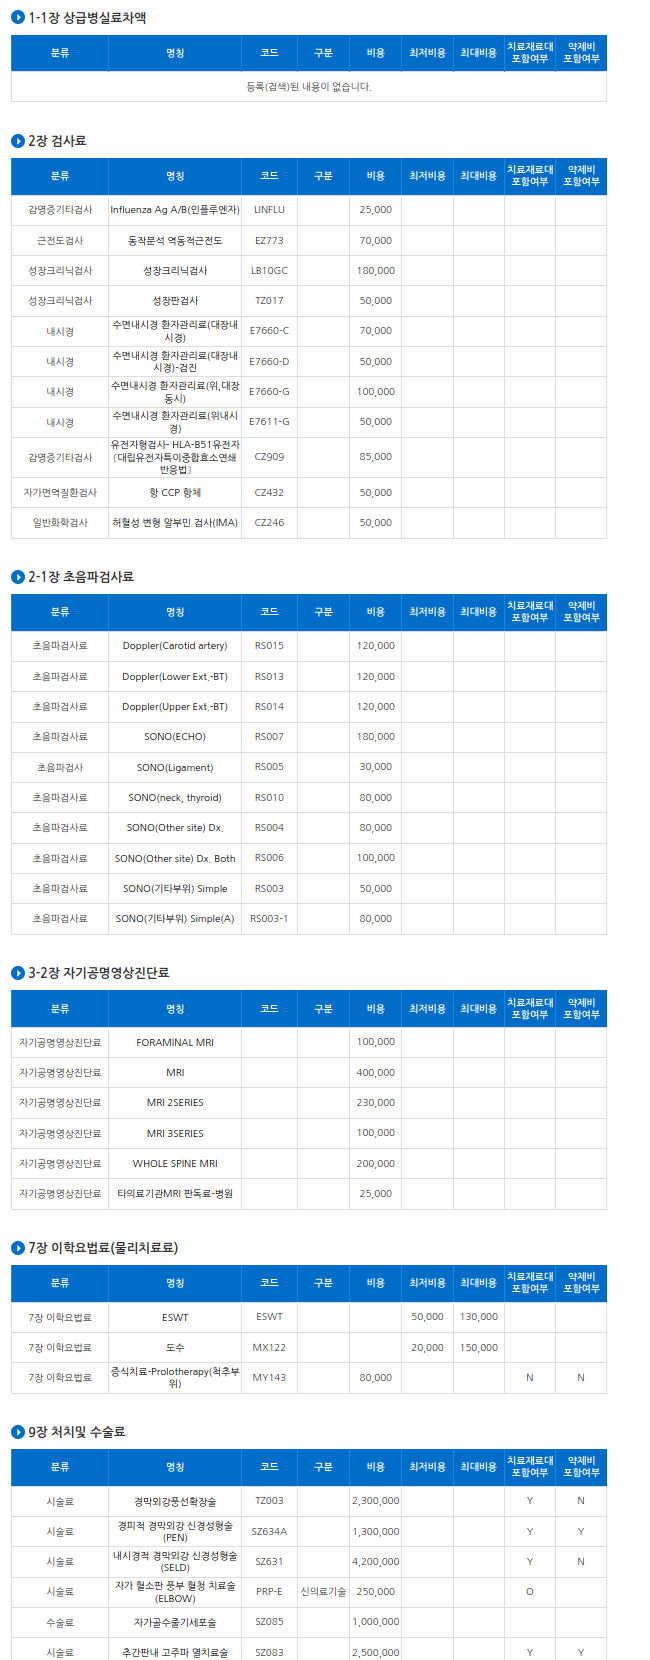

In [ ]:
table_list[-1][0]

In [ ]:
table_list[-1][1]

In [ ]:
table_list[-1][2]

In [ ]:
table_list[-1][3]

# case 2: 컬럼명 입력이 잘 안되는 경우(이중컬럼)

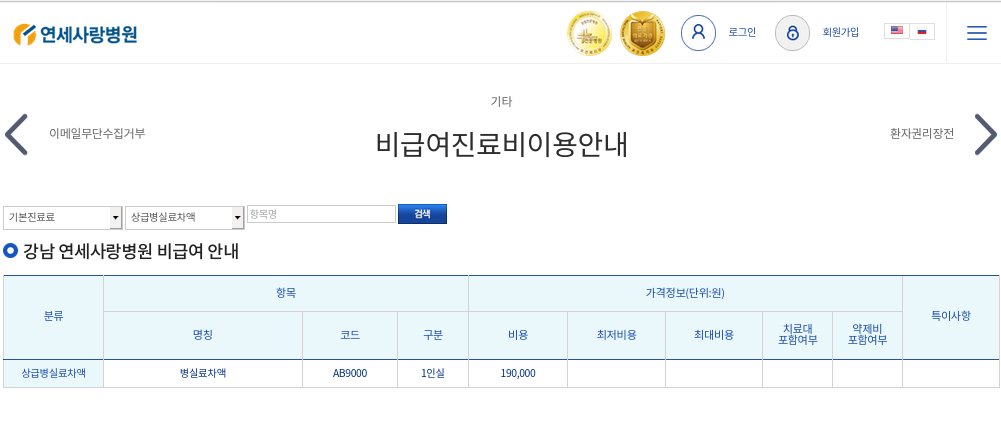

In [ ]:
table_list[0][0]

#  case 3: table parsing이 아예 안되는 경우

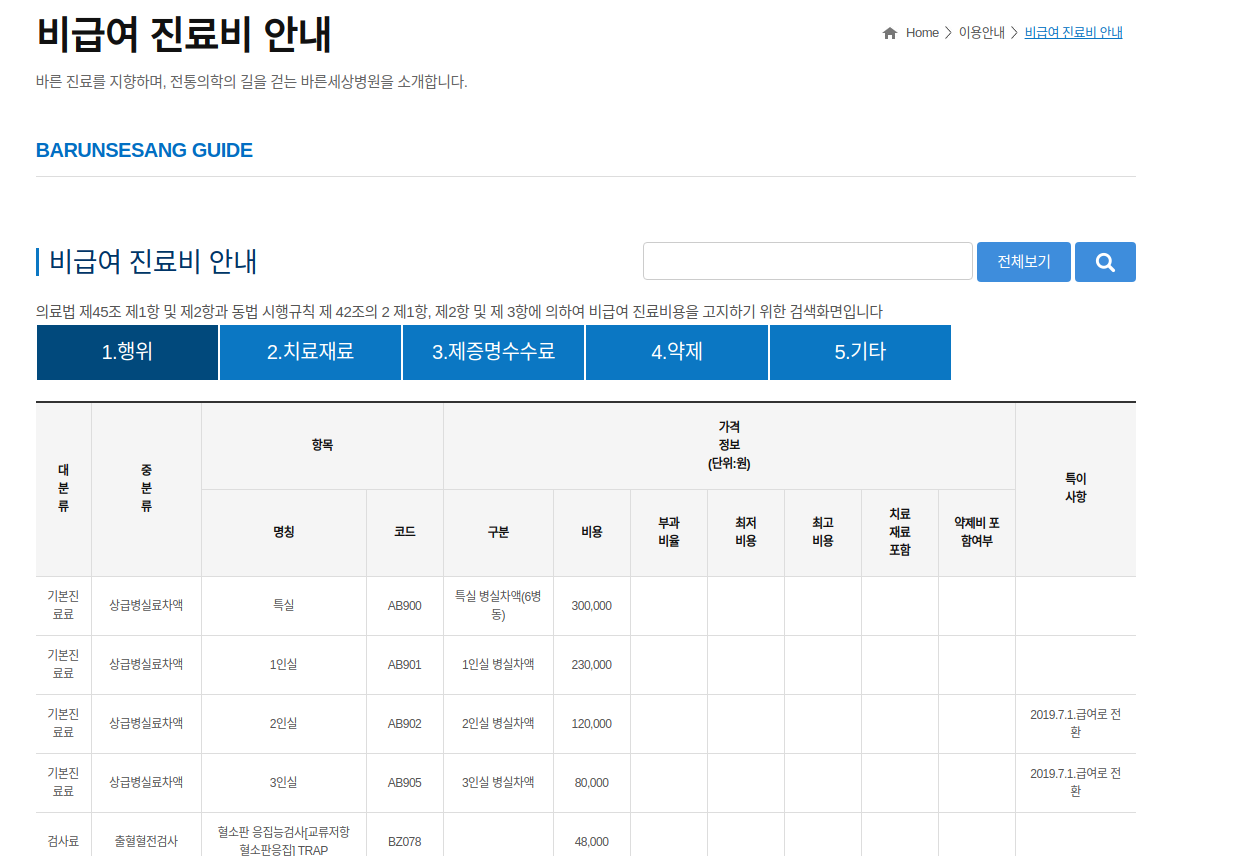

Selenium이라는 동적 패키지를 익히고 사용해야 해당 사이트 크롤링 가능